In [9]:
import Pkg

#Pkg.add("Optimisers")

using Flux
using Flux: onehotbatch, onecold, crossentropy
using MLDatasets
using CSV
using Random
using DataFrames
using Optimisers
using Statistics
using Plots


In [10]:
sunspot_data = CSV.read("Sunspot_data.csv", DataFrame)

sunspots = sunspot_data[:, 3];

In [11]:
function create_sequences(data, seq_len)
    X, y = [], []
    for i in 1:(length(data) - seq_len)
        push!(X, data[i:i+seq_len-1])
        push!(y, data[i+seq_len])
    end
    return hcat(X...), y  # Convert to matrix form
end

seq_len = 50  # Lookback window
X, y = create_sequences(sunspots, seq_len)

# Normalize
X = (X .- mean(X)) ./ std(X)
y = (y .- mean(y)) ./ std(y)

train_ratio = 0.8


split_var = Int(train_ratio * size(X, 2))

X_train, y_train = X[:, 1:split_var], y[1:split_var]
X_test, y_test = X[:, split_var+1:end], y[split_var+1:end]

X_train = reshape(X_train, size(X_train, 1), 1, size(X_train, 2))
X_test = reshape(X_test, size(X_test, 1), 1, size(X_test, 2))

y_train = reshape(y_train, 1, length(y_train))  # Convert to (1, batch_size)
y_test = reshape(y_test, 1, length(y_test))    # Convert to (1, batch_size)
;

In [12]:
model = Chain(
    Conv((5,), 1=>16, relu),
    MaxPool((2,)),
    BatchNorm(16),
    Conv((3,), 16=>32, relu),
    MaxPool((2,)),
    BatchNorm(32),
    Flux.flatten,
    Dense(320, 64, relu),  # Use 320 instead of 32
    Dense(64, 10, relu),
    Dense(10, 1),
     )    # Output a single prediction)
;

In [13]:
epochs = 200
batch_size = 64;

In [14]:
opt = ADAM()

data_loader = Flux.DataLoader((X_train, y_train), batchsize=batch_size, shuffle=true)

# Initialize optimizer state
opt_state = Flux.setup(opt, model)  

total_loss = []

for epoch in 1:epochs
    epoch_loss = 0
    for (x, y) in data_loader
        gs = Flux.gradient(model -> Flux.Losses.mse(model(x), y), model)[1]  
        Flux.update!(opt_state, Flux.trainable(model), gs)
        epoch_loss += Flux.Losses.mse(model(x), y)
    end
    println("Epoch $epoch - Train Loss: $epoch_loss")
    push!(total_loss, epoch_loss)
end


Epoch 1 - Train Loss: 16.924504421175183
Epoch 2 - Train Loss: 6.09781456322874
Epoch 3 - Train Loss: 4.557518945473643
Epoch 4 - Train Loss: 4.188370082538216
Epoch 5 - Train Loss: 3.6289594766237316
Epoch 6 - Train Loss: 3.47851428640809
Epoch 7 - Train Loss: 3.112267716580125
Epoch 8 - Train Loss: 2.8547522367852483
Epoch 9 - Train Loss: 2.5270117617017416
Epoch 10 - Train Loss: 2.3505893961708506
Epoch 11 - Train Loss: 2.171565158561786
Epoch 12 - Train Loss: 2.009219261299559
Epoch 13 - Train Loss: 1.9544429780213284
Epoch 14 - Train Loss: 2.1674537781393495
Epoch 15 - Train Loss: 1.685492864220304
Epoch 16 - Train Loss: 1.4668576102943087
Epoch 17 - Train Loss: 1.4134916684360703
Epoch 18 - Train Loss: 1.3216197033746666
Epoch 19 - Train Loss: 1.148994275187166
Epoch 20 - Train Loss: 1.112988861379381
Epoch 21 - Train Loss: 1.0704406151634698
Epoch 22 - Train Loss: 1.038128255267511
Epoch 23 - Train Loss: 1.0730666314964292
Epoch 24 - Train Loss: 0.9434730833147067
Epoch 25 - Tra

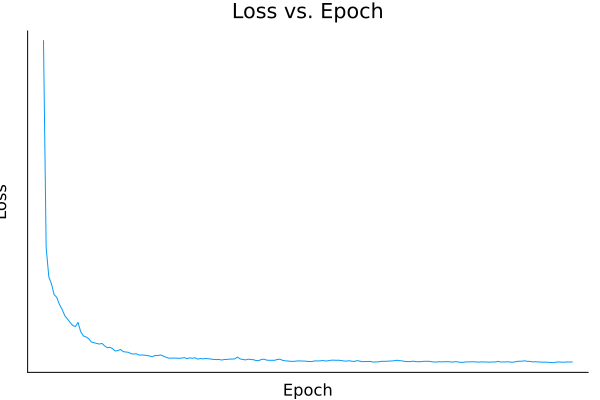

In [18]:
p1 = plot(1:epochs, total_loss, xlabel="Epoch", ylabel="Loss", title="Loss vs. Epoch", legend=false, xticks=false, yticks=false)
display(p1)

In [15]:
preds = model(X_test);


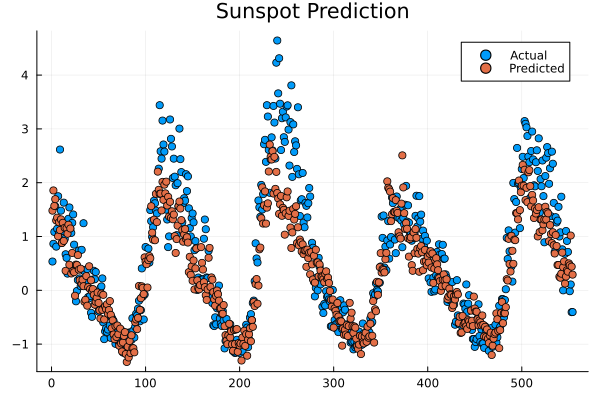

In [16]:
scatter(1:length(y_test[1, :]), y_test[1, :], label="Actual", title="Sunspot Prediction")
scatter!(1:length(preds[1, :]), preds[1, :], label="Predicted")